# Perform a basic acoustic wave simulation

The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates the basic functionality to perform acoustic simulations. The simulation consists of an incident plane wave in an unbounded water region and a spherical scatterer resembling bone.


## Import the OptimUS library

Load the OptimUS library.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

## Specify the physical settings for the simulation

The acoustic configuration of the models used in the library requires specifying several physical parameters. Specifically, a simulation needs a source of acoustic field, the geometry of the scatterer, and the material parameters.

The OptimUS library provides different predefined wave fields, among which a plane wave. The plane wave requires the frequency to be specified and, optionally, the wave direction and amplitude. The direction vector will be normalised by the OptimUS library.

In [3]:
frequency = 1000
source = optimus.source.create_planewave(frequency, direction=(1,1,0))

Several canonical shapes for scatterers are available in the OptimUS library. Let us use a spherical geometry, by default centered at the origin and unit radius. It is recommended to specify the meshwidth of the triangular surface grid that represents the geometry's surface. A lower value of `element_size` increases the precision of the algorithm but also the computational costs.

In [4]:
geometry = optimus.geometry.shapes.Sphere(element_size=0.4)

The library has a database with parameters for materials commonly used in acoustic simulations. Here, let us use water as exterior domain and cortical bone for the scatterer.

In [5]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. A mathematical model with default settings can be used.

Each model requires a source and geometry object, as well as the material parameters of the unbounded exterior domain and the bounded interior domain.

In [6]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the instance of the model object.

In [7]:
model.solve()

## Visualisation of the acoustic field

With the surface potential calculated by the BEM, the acoustic field can be visualised in arbitrary points. Let us visualise the acoustic pressure on a horizontal plane through the center of the sphere.

In [8]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(bounding_box=[-3, 5, -3, 4])
postprocess_plane.compute_fields()

By default, the library shows the real part and absolute value of the total pressure field in Pascal. Notice that the amplitude of the incident wave field was normalised to one.

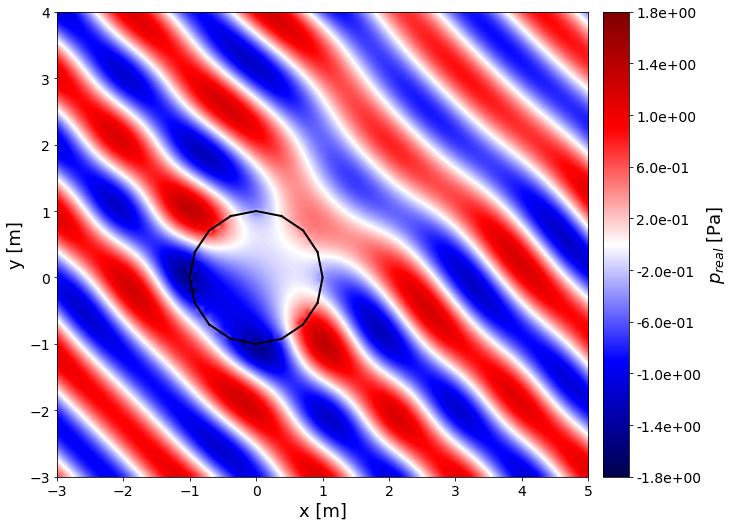

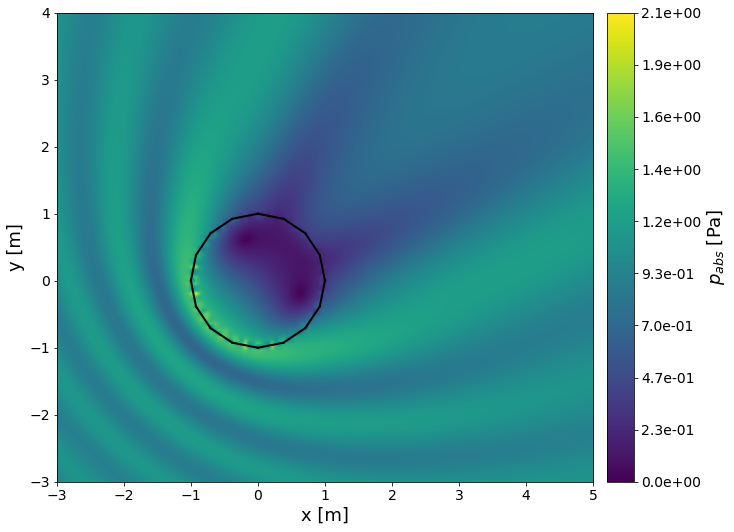

In [9]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane)